Title:
Author:
Date: 
Github: https://github.com/marietolteca00/biodiversity_intact_phoenix.git

### Citation
- Microsoft Planetary Computer. io‑biodiversity Dataset. https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview
- U.S. Census Bureau. 2020 TIGER/Line® Shapefiles: County Subdivisions. https://www.census.gov/cgi‑bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely import box
import pystac_client
import planetary_computer
import contextily as ctx
import matplotlib.patches as mpatches

from IPython.display import Image 

### Data Citation
- Census County Subdivision shapefiles (TIGER/Line 2020) - `tl_2020_04_cousub`
- Microsoft Planetary Computer - `io-biodiversity collection` (BII time series)

### Import Arizona Shapefile

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

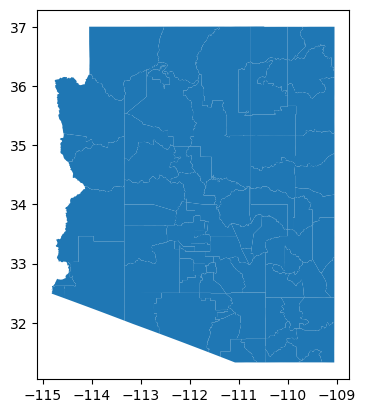

In [2]:
# Import Shapefile for Arizona
arizona = gpd.read_file(os.path.join('data',
                                'tl_2020_04_cousub',   
                                'tl_2020_04_cousub.shp'))

arizona.plot()

# Check CRS for Shapefile
arizona.crs #EPSG: 4269


In [3]:
# Check first 5 rows of Dataframe
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."
3,04,003,90408,01934925,0400390408,Bowie,Bowie CCD,22,Z5,G4040,None,None,None,S,3556140749,1110460,+32.1699052,-109.3999964,"POLYGON ((-109.76866 32.30583, -109.76787 32.3..."
4,04,003,93825,01934992,0400393825,Willcox,Willcox CCD,22,Z5,G4040,None,None,None,S,1898081614,4959613,+32.1980984,-109.8877527,"POLYGON ((-110.15218 32.17203, -110.15213 32.1..."


This CRS for Phoenix is: EPSG:4269


<Axes: >

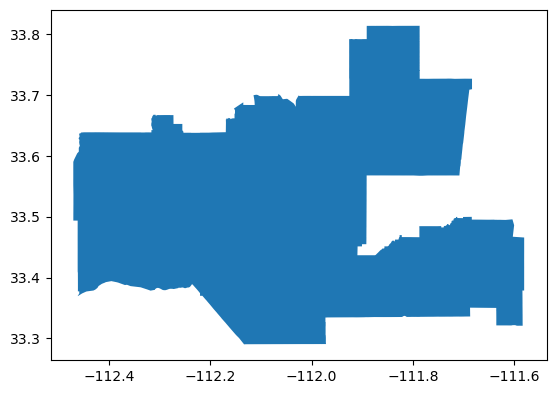

In [4]:
# Check if Phoenix exist in df
phoenix_names = arizona[arizona['NAME'].str.contains("Phoenix", case=False, na=False)]

# Create a copy to avoid any issues
phoenix = arizona[arizona['NAME'].str.contains("Phoenix", case=False, na=False)].copy()

# Verify if there are any errors
assert len(phoenix)

# CRS
print(f'This CRS for Phoenix is: {phoenix.crs}')

# Plot it 
phoenix.plot()

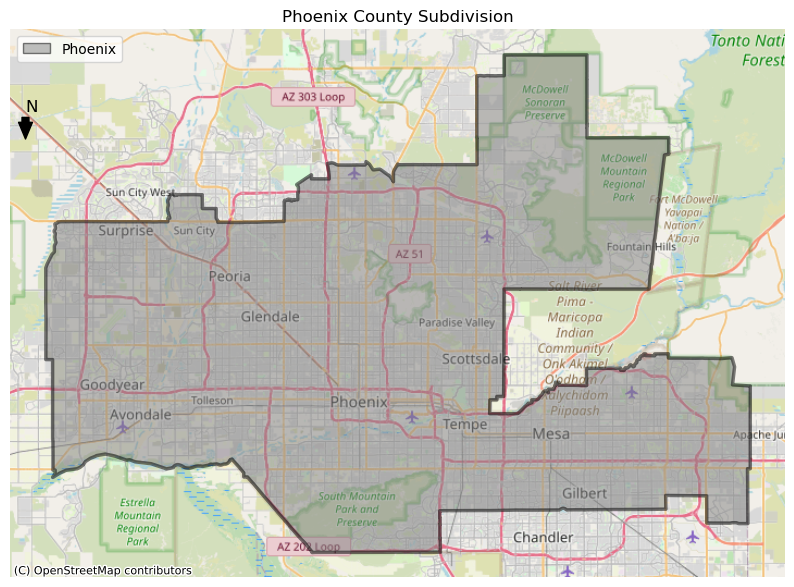

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

# Reproject Phoenix 
phoenix = phoenix.to_crs(epsg=3857)

# Plot Phoenix subdivision
phoenix.plot(ax=ax, linewidth=2.5, 
             edgecolor="black", 
             facecolor="grey", 
             alpha = 0.5,
             label= "Phoenix")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Phoenix County Subdivision", fontsize=12)
ax.set_axis_off()

# Legend
legend_patch = mpatches.Patch(facecolor='grey', edgecolor='black', alpha=0.5, label='Phoenix')
ax.legend(handles=[legend_patch], loc='upper left')

# North Arrow
x_arrow, y_arrow = 0.02, 0.8 # Horizontal, Vertical
ax.annotate('N', xy=(x_arrow, y_arrow), xytext=(x_arrow, y_arrow+0.05),
            arrowprops=dict(facecolor='black', width=5, headwidth=10),
            fontsize=12, xycoords=ax.transAxes)


plt.show()



In the Data exploration I was bale to look at the first five rows of the data to see if the type of rows and information it contained. Since we are focused in phoenix, a filtered search was made and place in a variable. The variable was plotted to make sure the city of Phoenix was correctly extracted.

# Use Catalog Search to Grab Data
Connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for Biodiversity Intactness Index (Bll) Time Series data is `io-biodiversity`. This uses the 2017 - 2020 Rasters covering the Phoenix subdivision.

In [6]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set Bounding Box Coordinates
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search MPC Datalog
search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_of_interest)


# Retrieve Search Items
items = search.item_collection()
print(f'Returned{len(items)} items')

items


Returned4 items


In [7]:
# Search MPC Datalog for 2017
search_2017 = catalog.search(
    collections=["io-biodiversity"],
    bbox=bbox_of_interest,
    datetime="2017-01-01/2017-12-31"
)
items_2017 = list(search_2017.get_items())
items_2017 = items_2017[0]


# Search MPC Datalog for 2020
search_2020 = catalog.search(
    collections=["io-biodiversity"],
    bbox=bbox_of_interest,
    datetime="2020-01-01/2020-12-31"
)
items_2020 = list(search_2020.get_items())
items_2020 = items_2020[0]

/Users/marietolteca/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [8]:
# Access Raster Data from item
raster_2017 = rioxr.open_rasterio(items_2017.assets['data'].href)
# View raster
raster_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [9]:
# Access Raster Data from item
raster_2020 = rioxr.open_rasterio(items_2020.assets['data'].href)
# View raster
raster_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Notice that 'band' is dimension of length 1. We can go ahead and "squeeze" the raster to simplify it:

In [10]:
# Remove Length  dimension (band)
raster_2017 = raster_2017.squeeze().drop_vars('band')

print("Size of dimension:", dict(raster_2017.sizes))

# Remove Length  dimension (band)
raster_2020 = raster_2020.squeeze().drop_vars('band')

print("Size of dimension:", dict(raster_2020.sizes))

Size of dimension: {'y': 7992, 'x': 7992}
Size of dimension: {'y': 7992, 'x': 7992}


In [11]:
# Check CRS for both Data Array and Shapefile
print("Raster CRS:", raster_2017.rio.crs)
print("Phoenix CRS:", phoenix.crs)

# Transform Phoenix to match Raster
phoenix = phoenix.to_crs(raster_2017.rio.crs)

print("Phoenix Transformed CRS:", phoenix.crs)

# Create GeoDataFrame from raster bounary box
raster_bbox = gpd.GeoDataFrame(geometry= [box(*raster_2017.rio.bounds())],
                             crs = raster_2017.rio.crs)

print(raster_bbox)

Raster CRS: EPSG:4326
Phoenix CRS: EPSG:3857
Phoenix Transformed CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
                                            geometry
0  POLYGON ((-108.20664 27.56531, -108.20664 34.7...


In [12]:
# Clip Raster 2017 to Phoenix 
raster_2017_clip = raster_2017.rio.clip(phoenix.geometry, phoenix.crs, 
                               drop=False)

# Clip Raster 2020 to Phoenix 
raster_2020_clip = raster_2020.rio.clip(phoenix.geometry, phoenix.crs, 
                               drop=False)


In [13]:
# 2017
values_2017 = raster_2017_clip.values
valid_mask_2017 = ~np.isnan(values_2017)
count_total_2017 = np.count_nonzero(valid_mask_2017)
count_ge_2017 = np.count_nonzero((values_2017 >= 0.75) & valid_mask_2017)
percent_2017 = (count_ge_2017 / count_total_2017) * 100

# 2020
values_2020 = raster_2020_clip.values
valid_mask_2020 = ~np.isnan(values_2020)
count_total_2020 = np.count_nonzero(valid_mask_2020)
count_ge_2020 = np.count_nonzero((values_2020 >= 0.75) & valid_mask_2020)
percent_2020 = (count_ge_2020 / count_total_2020) * 100


In [17]:
# Create mask: BII >= 0.75 in 2017 AND < 0.75 in 2020
mask_lost = (raster_2017_clip.values >= 0.75) & (raster_2020_clip.values < 0.75)


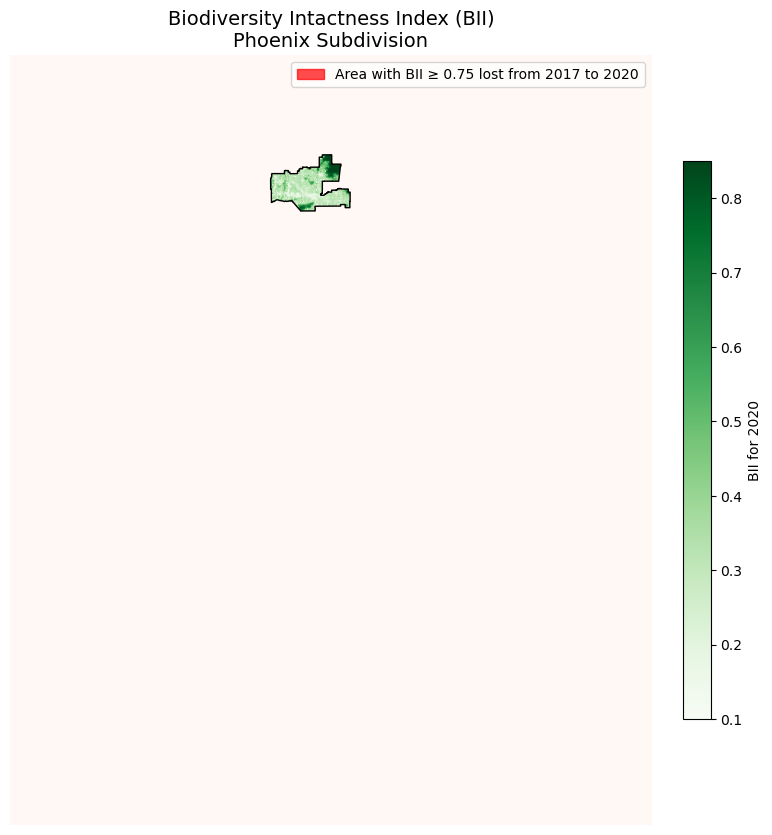

In [18]:

# Plot
fig, ax = plt.subplots(figsize=(10,10))

# Plot raster for 2020
raster_2017_clip.plot(ax=ax, cmap='Greens', vmin=0.1, vmax=0.85, add_colorbar=False)

# Overlay lost BII ≥0.75 in red
extent = raster_2017_clip.rio.bounds()
mask_lost_numeric = mask_lost.astype(int)
ax.imshow(mask_lost_numeric, cmap='Reds', alpha=0.7, extent=raster_2017_clip.rio.bounds(), origin='upper')

# Overlay Phoenix boundary
phoenix.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Legend for lost BII
legend_patch = mpatches.Patch(color='red', alpha=0.7, label='Area with BII ≥ 0.75 lost from 2017 to 2020')
ax.legend(handles=[legend_patch], loc='upper right')

# Add colorbar for 2020 BII
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0.1, vmax=0.85))
cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('BII for 2020')

ax.set_title("Biodiversity Intactness Index (BII)\nPhoenix Subdivision", fontsize=14)
ax.set_axis_off()
plt.show()


In [16]:
# df = pd.DataFrame({
#     "Year": [2017, 2020],
#     "Percent BII ≥ 0.75": [percent_2017, percent_2020]
# })

# print(df)